# Anytime K-Means

### Authors: Alex Jude, Madhumetha Ramesh, Yogeshkarna Govindaraj

Reference:
    https://pcl.readthedocs.io/projects/tutorials/en/latest/walkthrough.html#walkthrough

## Data Acquisition

In [1]:
import numpy as np 
import open3d as o3d
import pclpy
from pclpy import pcl
from sklearn.metrics import silhouette_samples, silhouette_score

In [2]:
# Read .ply file
# input_file = "segmented_cloud.ply"
input_file = "data/bun_zipper.ply"
# Read the point cloud 
pcd = o3d.io.read_point_cloud(input_file) 

In [3]:
# Visualize the point cloud within open3d
o3d.visualization.draw_geometries([pcd]) 

# Convert open3d format to numpy array
# Here, you have the point cloud in numpy format. 
dataset = np.asarray(pcd.points)

## Statistical Outlier Removal 

In [4]:
def display_inlier_outlier(cloud, ind):
    inlier_cloud = cloud.select_by_index(ind)
    outlier_cloud = cloud.select_by_index(ind, invert=True)

    print("Showing outliers (red) and inliers (gray): ")
    outlier_cloud.paint_uniform_color([1, 0, 0])
    inlier_cloud.paint_uniform_color([0.8, 0.8, 0.8])
    o3d.visualization.draw_geometries([inlier_cloud, outlier_cloud],
                                      zoom=0.3412,
                                      front=[0.4257, -0.2125, -0.8795],
                                      lookat=[2.6172, 2.0475, 1.532],
                                      up=[-0.0694, -0.9768, 0.2024])
    
print("Statistical oulier removal")
cl, ind = pcd.remove_statistical_outlier(nb_neighbors=10,std_ratio=20)
filtered_pcd = pcd.select_by_index(ind)
display_inlier_outlier(pcd, ind)

Statistical oulier removal
Showing outliers (red) and inliers (gray): 


In [5]:
pcd_pp = pcd.select_by_index(ind)
# o3d.io.write_point_cloud("dataset_3d.xyz", pcd_pp)

#View dataset
dataset_3d = np.asarray(pcd_pp.points)
print(dataset_3d)

[[-0.0378297   0.12794     0.00447467]
 [-0.0447794   0.128887    0.00190497]
 [-0.0680095   0.151244    0.0371953 ]
 ...
 [-0.0704544   0.150585   -0.0434585 ]
 [-0.0310262   0.153728   -0.00354608]
 [-0.0400442   0.15362    -0.00816685]]


## K-means initial testing with 2D dataset

In [6]:
import numpy as np
import matplotlib.pyplot as plt
import pandas as pd
import seaborn as sns
import sklearn
from sklearn.cluster import KMeans,DBSCAN
import json

### 2D points generation

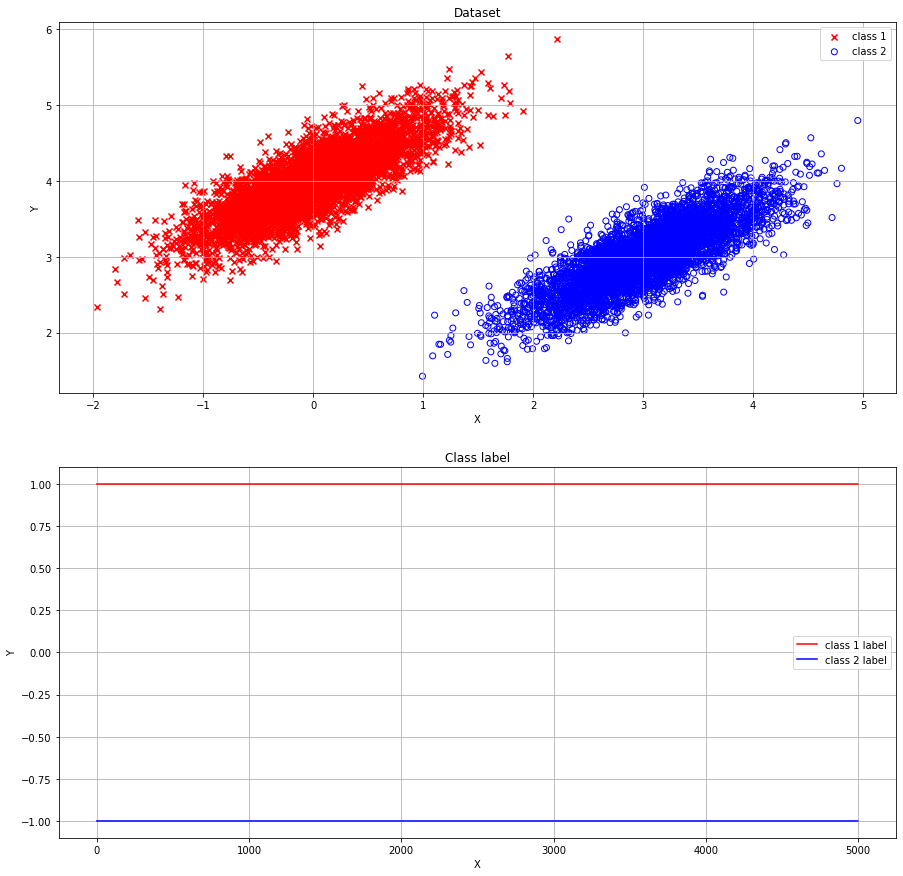

In [7]:
#parameters
mean1= [0,4]
mean2= [3,3]
cov = np.array([[0.3,0.2],[0.2,0.2]])
total_points = 5000
#dataset
dataset1 = np.random.multivariate_normal(mean1,cov,total_points)
dataset2 = np.random.multivariate_normal(mean2,cov,total_points)
d1label = np.ones(total_points)
d2label = np.full(total_points,-1)
#plot
fig, ax = plt.subplots(2,1,figsize=(15,15))
ax[0].scatter(dataset1[:,0],dataset1[:,1],label='class 1',c= 'r',marker='x')
ax[0].scatter(dataset2[:,0],dataset2[:,1],label='class 2',facecolors='none', edgecolors='b')
ax[0].set_title('Dataset')
ax[0].set_xlabel('X')
ax[0].set_ylabel('Y')
ax[0].legend()
ax[0].grid(True)

ax[1].plot(d1label,label='class 1 label',c= 'r')
ax[1].plot(d2label,label='class 2 label',c= 'b')
ax[1].set_title('Class label')
ax[1].set_xlabel('X')
ax[1].set_ylabel('Y')
ax[1].legend()
ax[1].grid(True)

### Using K-Means Scipy library for clustering 

For n_clusters = 2 The average silhouette_score is : 0.743802821842383
For n_clusters = 3 The average silhouette_score is : 0.6013735353041421
For n_clusters = 4 The average silhouette_score is : 0.478572540578333


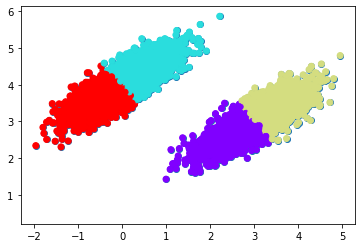

In [9]:
#stacking the dataset 
X = np.vstack((dataset1,dataset2))

plt.scatter(X[:,0],X[:,1], label='True Position')
val=[]
for n_clusters in range(2,5):

    #k-means clustering 
    kmeans = KMeans(n_clusters)
    cluster_labels = kmeans.fit_predict(X)

    silhouette_avg = silhouette_score(X, cluster_labels )
    val.append(silhouette_avg)
    print("For n_clusters =", n_clusters,
          "The average silhouette_score is :", silhouette_avg)

plt.plot(silhouette_avg)
plt.scatter(X[:,0],X[:,1], c=kmeans.labels_, cmap='rainbow')

### Saving quality vector for anytime library tesing 

In [ ]:
val1= []
for i in val:
    val1.append(i)
    
jsonStr = json.dumps(val1)
with open('data.json', 'w') as outfile: 
    json.dump(jsonStr, outfile)

## Anytime K-Means for 3D point clouds implementation 

In [ ]:
import matplotlib.image as img 
import time
from sklearn.cluster import KMeans
import scipy.misc
import random
import numpy.matlib
import os
import imageio

In [ ]:
start_time = time.time() #initialize time counter

def sampleClosestCentroid(points,centroids):
    #Function to assign each sample to the closest centroids
    K = np.size(centroids,0)
    arr = np.empty((np.size(points,0),1))
    for i in range(0,K):
        #Closest centroid finding
        temp = np.ones((np.size(points,0),1))*centroids[i]
        b = np.power(np.subtract(points,temp),2)
        a = np.asarray(np.sum(b,axis=1))
        a.resize((np.size(points,0),1))
        arr = np.append(arr, a, axis=1)
    arr = np.delete(arr,0,axis=1)
    
    #closest centroid index which has minimum distance
    index = np.argmin(arr, axis=1)
    return index

def adjustCentroidsMean(points,index,K):
    #Function to adjust the centroids to the mean of the sample assigned
    n = np.size(points,1)
    
    #mean matrix
    centroids = np.zeros((K,n))
    
    # loop to calculate mean of points 
    for i in range(0,K):
        clusteridx = index==i
        clusteridx = clusteridx.astype(int)
        total_number = sum(clusteridx);
        clusteridx.resize((np.size(points,0),1))
        total_matrix = np.matlib.repmat(clusteridx,1,n)
        total = np.multiply(points,total_matrix)
        
        #adjusting centroids w.r.t mean
        centroids[i] = (1/total_number)*np.sum(total,axis=0)
        
    return centroids

def kMeansClustering(points,centroids,iterations):
    m = np.size(points,0)
    n = np.size(points,1)
    K = np.size(initial_centroids,0)
    index = np.zeros((m,1))
    
    for i in range(1,iterations):
        #Assign each sample to the closest centroid
        index = sampleClosestCentroid(points,centroids)
        
        #Adjust the centroids to be the means of the samples assigned to them.
        centroids = adjustCentroidsMean(points,index,K)
        
    return centroids,index
    
if __name__ == '__main__': 
    
    print("Kmeans clustering")
    #Assign parameters
    
    print('###############################################################')
    clusters = 100
    iterations = 5#number of iterations
    print("Number of centroids initialized: ", clusters)
    print("Number of iterations initialized: ", iterations)
    print('###############################################################')
    
    points= dataset_3d
    #Sample the initial centroids 
    #initializing centroids at aribitrary location
    initial_centroids = random.sample(list(points),clusters)
    
    #K-means algorithm
    centroids, index= kMeansClustering(points,initial_centroids,iterations)

    plt.scatter(centroids[:,0],centroids[:,1], cmap='rainbow')
    
    #printing runtime
    print("Runtime: %s seconds" % (time.time() - start_time))
    print('###############################################################')
    time.sleep(2) # wait to save the image 
    

### Output visualisation

In [ ]:
output = np.hstack((dataset_3d,a))
compressed= centroids
np.savetxt("output_compresed.txt", compressed)
np.savetxt("output.txt", output)
pcd_c = o3d.io.read_point_cloud("output_compresed.txt", format='xyz')
o3d.visualization.draw_geometries([pcd_c]) 

### K-Means 3D point cloud using Scipy library

In [ ]:
kmeans_3d = KMeans(n_clusters= 1000,n_init=2, verbose=0)
kmeans_3d.fit_predict(dataset_3d)
labels_3d= kmeans_3d.labels_
centroids = kmeans_3d.cluster_centers_

labels_3d = labels_3d/ max(labels_3d)
print(labels_3d)
viridis = plt.cm.get_cmap('viridis', 8)
colors= viridis(labels_3d)
print(colors)
a = colors[:,:3]
print(a)

### Output visualisation

In [ ]:
output = np.hstack((dataset_3d,a))
compressed= centroids
np.savetxt("output_compresed.txt", compressed)
np.savetxt("output.txt", output)
pcd_c = o3d.io.read_point_cloud("output_compresed.txt", format='xyz')
pcd = o3d.io.read_point_cloud("output.txt", format='xyzrgb')
o3d.visualization.draw_geometries([pcd]) 
o3d.visualization.draw_geometries([pcd_c]) 